<h1> Cryptoanalysis of a text file encrypted Vigenere cipher </h1>

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import math
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad, simpson
from scipy.stats import poisson
from scipy.interpolate import interp1d
from multiprocessing import Pool, Manager, Value
from functools import partial, reduce
#from LISAhdf5 import LISAhdf5,ParsUnits
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

We have to decypher the message :

In [2]:
Encoded_mex = "TUIRDSFOGKYLBVLOORXXRVDPL"\
              "SHRSBPOCBTTLQPGAOMHMSVONM"\
              "HDHDNTRTCXRYCJLNHGHTBRIIM"\
              "HHQWBNHGTIERDAXBHWCZIQGEB"\
              "RHRQRTKSGXVRZJMIRBXGBXQWT"\
              "RHGIUELXXGGDIIAOUWIBEVAPR"\
              "DHQXWEWCTQTHBSFAUHXTLOOLN"\
              "NWWAMHHOHBAQUPFEVGRAEGIAX"\
              "DICGLESHTFBHFGXMRJXGGPOGM"\
              "IDZATWZCJEDESPLIJBPEAGWEE"\
              "OPOILALREXOSZTPOXZSMANSXM"\
              "TRATTNWVPMWKOIAASDTGEGPTY"\
              "OUSRHUORHMAUHJIAJOXGIQOHM"\
              "AWSRHUQQXEMHSIBNJCCPEGBTL"\
              "DDMBKLLRTYEQRTWBHWYBNJGJL"\
              "ERTBBLLHPKYICGVEWCRKAFYSH"\
              "WQCCMHHGINDHBIFOYSBXNWHWX"\
              "CUIHAIQUDYTKSRHUQHTKRHJDE"

Let's start by defining a function to estimate the frequency of the characters in the text !

In [3]:
def CharFrequencies(string):
    # Given a string, returns a dictionary with the frequencies of all the characters in the string
    char_freq = {
    'A' : 0.,
    'B' : 0.,
    'C' : 0.,
    'D' : 0.,
    'E' : 0.,
    'F' : 0.,
    'G' : 0.,
    'H' : 0.,
    'I' : 0.,
    'J' : 0.,
    'K' : 0.,
    'L' : 0.,
    'M' : 0.,
    'N' : 0.,
    'O' : 0.,
    'P' : 0.,
    'Q' : 0.,
    'R' : 0.,
    'S' : 0.,
    'T' : 0.,
    'U' : 0.,
    'V' : 0.,
    'W' : 0.,
    'X' : 0.,
    'Y' : 0.,
    'Z' : 0. 
    }
    
    for i in string:
            char_freq[i] += 1./len(string)
    
    return char_freq

we can hence see that :

In [4]:
Frequencies = CharFrequencies(Encoded_mex)
Frequencies

{'A': 0.04666666666666667,
 'B': 0.051111111111111114,
 'C': 0.031111111111111114,
 'D': 0.035555555555555556,
 'E': 0.04666666666666667,
 'F': 0.015555555555555557,
 'G': 0.05555555555555556,
 'H': 0.08222222222222222,
 'I': 0.05333333333333334,
 'J': 0.024444444444444446,
 'K': 0.017777777777777778,
 'L': 0.04,
 'M': 0.035555555555555556,
 'N': 0.02666666666666667,
 'O': 0.04666666666666667,
 'P': 0.031111111111111114,
 'Q': 0.03333333333333333,
 'R': 0.06222222222222223,
 'S': 0.04,
 'T': 0.05777777777777778,
 'U': 0.02666666666666667,
 'V': 0.017777777777777778,
 'W': 0.042222222222222223,
 'X': 0.04666666666666667,
 'Y': 0.02,
 'Z': 0.013333333333333334}

and these values can be used to have a first hint on the lenght of the key using the [Index of Coincidence](http://practicalcryptography.com/cryptanalysis/text-characterisation/index-coincidence/), which can be estimated from the frequencies of the text using the following function :

In [5]:
def IC_Analysis(Frq_char):
    # This function, receive a dictionary with the frequency of each character of a text and give informations by computing it's IC
    Ic = 0.
    for i in Frq_char:
        Ic += Frq_char[i]**2.
    print('The value of Index of coincidence estimated for the text is : ',Ic)
    
    if(Ic > 0.052):
        print('The text is likely to come from a single alphabet! \nConsult the IC table to find one which one is more likely !')
    elif(Ic > 0.0440):
        print('The text is likely to have been cyphered with 2 to 5 different alphabets !')
    elif(Ic > 0.041):
        print('The text is likely to have been cyphered with 5 to 10 different alphabets!')
    else:
        print('The text either has more than 10 alphabets or is a random text, good luck !')

In [6]:
IC_Analysis(Frequencies)

The value of Index of coincidence estimated for the text is :  0.04525432098765432
The text is likely to have been cyphered with 2 to 5 different alphabets !


After this first interesting information, we can proceed with the [Kasisky Test](https://en.wikipedia.org/wiki/Kasiski_examination) to double check if our first esteem makes sense.
Let's define a function to do this test :

In [7]:
def Check_String_Repeatition(String, Str_len):
    # Given a string, it decompose that in smaller stringhs of lenght Str_len and it checks the original one for how many times each small piece appear and at which locations
    
    checked = {}
    
    for i in range(len(String) - Str_len):
        if (String.count(String[i:i + Str_len]) > 1 and String[i:i + Str_len] not in checked):
            
            checked[String[i:i + Str_len]] = String.count(String[i:i + Str_len])
            print('The word ',String[i:i + Str_len],' appears ',String.count(String[i:i + Str_len]), 'times in the text')
    
            
    return checked
    

In [8]:
Dupes = Check_String_Repeatition(Encoded_mex, 3)

The word  LOO  appears  2 times in the text
The word  NHG  appears  2 times in the text
The word  MHH  appears  3 times in the text
The word  BHW  appears  2 times in the text
The word  QRT  appears  2 times in the text
The word  TKS  appears  2 times in the text
The word  HGI  appears  2 times in the text
The word  XGG  appears  2 times in the text
The word  EWC  appears  2 times in the text
The word  AUH  appears  2 times in the text
The word  ICG  appears  2 times in the text
The word  SRH  appears  3 times in the text
The word  RHU  appears  3 times in the text
The word  HMA  appears  2 times in the text
The word  HUQ  appears  2 times in the text
The word  BNJ  appears  2 times in the text


we now have to check at which location the sub-strings repeat, in order  to use the Kasisky test to try to guess the key :

In [9]:
def dupes_str_indexes(string, sub_string):
    #Given a string and a substring it returns an array with the indexes at which the substring appears
    indexes = np.linspace(0,1,string.count(sub_string))
    j = 0
    for i in range(len(string) - len(sub_string)):
        if string[i: i + len(sub_string)] == sub_string:
            indexes[j] = i
            j += 1
    
    print('The substring ',sub_string, ' was found at locations ', indexes)
    return indexes.astype(int)

and we can run the previously defined function on all the dupes we previously found to see the indexes and their _greatest common divisor (GCD)_, indeed we are gonna ignore the cases when $GCD = 1$:

In [10]:
for w in Dupes:
    idxs = dupes_str_indexes(Encoded_mex, w)
    if len(idxs) > 2:
        if reduce(math.gcd,idxs) > 1 :
             print('The greatest common divisor for the indexes of the substring ',w,' is ',reduce(math.gcd,idxs))
    else:
        if math.gcd(idxs[0], idxs[1]) > 1 :
             print('The greatest common divisor for the indexes of the substring ',w,' is ',math.gcd(idxs[0], idxs[1]))

The substring  LOO  was found at locations  [ 14. 170.]
The greatest common divisor for the indexes of the substring  LOO  is  2
The substring  NHG  was found at locations  [65. 80.]
The greatest common divisor for the indexes of the substring  NHG  is  5
The substring  MHH  was found at locations  [ 74. 179. 404.]
The substring  BHW  was found at locations  [ 90. 365.]
The greatest common divisor for the indexes of the substring  BHW  is  5
The substring  QRT  was found at locations  [103. 361.]
The substring  TKS  was found at locations  [105. 435.]
The greatest common divisor for the indexes of the substring  TKS  is  15
The substring  HGI  was found at locations  [126. 406.]
The greatest common divisor for the indexes of the substring  HGI  is  14
The substring  XGG  was found at locations  [133. 218.]
The substring  EWC  was found at locations  [155. 390.]
The greatest common divisor for the indexes of the substring  EWC  is  5
The substring  AUH  was found at locations  [165. 310

Statistically speaking, we can see that most of times the _GCD_ is either $5$ or one of its multiple, we are gonna hence assume that the lenght of the key will be 5 ! 
We can hence set :

In [11]:
key_len = 5

We can now decompose the original messages in $n$ messages where $n$ is the lenght of the key !

In [12]:
def StrDecompose(string, key_len):
    #Given a string and the lenght of the assumed key, this function will return key_len different strings by decomposing the original message
    
    Dec_strs = {}
    
    for i in range(key_len):
        Dec_strs[i] = string[i::key_len]
    
    return Dec_strs
    
    

the decomposed strings would be given by :

In [13]:
Dec_mexs = StrDecompose(Encoded_mex, key_len)
Dec_mexs

{0: 'TSYORSPTASHTRNBHNEBIRTVIBREGOEDETALNHAEEDEBMGIWDIAOAOOATNWAEOUAAIAUMNEDLEBNELYEAWHDONCITUR',
 1: 'UFLOVHOLOVDRYHRHHRHQHKRRXHLDUVHWHUOWHQVGISHRPDZEJGPLSXNRWKSGUOUJQWQHJGDLQHJRLIWFQHHYWUQKQH',
 2: 'IOBRDRCQMOHTCGIQGDWGRSZBQGXIWAQCBHOWOUGICHFJOZCSBWORZZSAVODPSRHOOSQSCBMRRWGTHCCYCGBSHIUSHJ',
 3: 'RGVXPSBPHNDCJHIWTACEQGJXWIXIIPXTSXLAHPRAGTGXGAJPPEIETSXTPITTRHJXHRXICTBTTYJBPGRSCIIBWHDRTD',
 4: 'DKLXLBTGMMNXLTMBIXZBRXMGTUGABRWQFTNMBFAXLFXGMTELEELXPMMTMAGYHMIGMHEBPLKYWBLBKVKHMNFXXAYHKE'}

We can hence proceed with a frequence analysis on the various sub_messages :

In [14]:
Frq_submexs = {}

for i in range(key_len):
    Frq_submexs[i] = CharFrequencies(Dec_mexs[i])

let's plot the results to give a bit more insight :

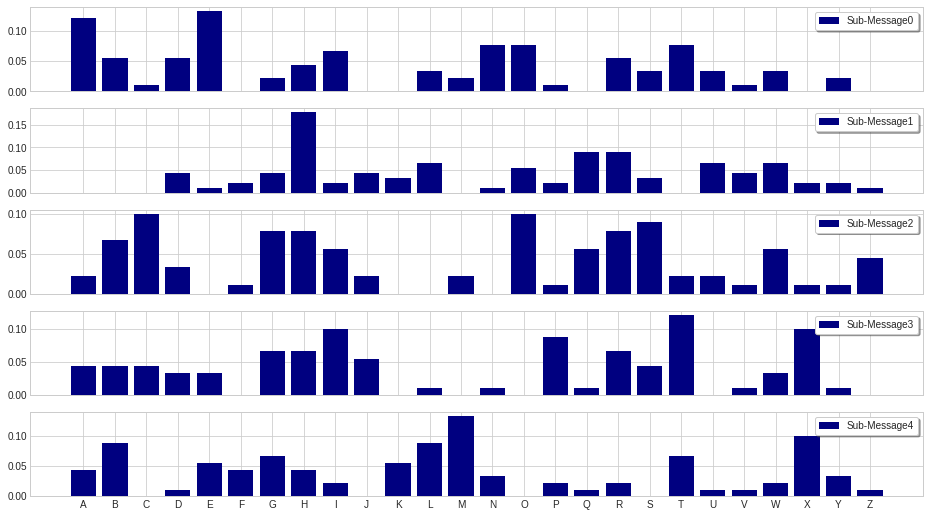

In [15]:
fig, ax = plt.subplots(key_len, 1, sharex='col', figsize = (16,9))
for i in range(key_len):
     ax[i].bar(Frq_submexs[i].keys(), Frq_submexs[i].values(), color='navy',label = 'Sub-Message'+str(i))
     ax[i].legend(loc = 1, frameon = True, fancybox = True, shadow = True)
     
    

We have to look at which of the 5 message is the more close to a proper english message, to do so we have to estimate the _IC_ for each of the 5 sub_messages, we get :

In [16]:
for i in range(key_len):
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')
    print('We are now considering the submessage indexed by ',i)
    IC_Analysis(Frq_submexs[i])

print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')

-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
We are now considering the submessage indexed by  0
The value of Index of coincidence estimated for the text is :  0.0728395061728395
The text is likely to come from a single alphabet! 
Consult the IC table to find one which one is more likely !
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
We are now considering the submessage indexed by  1
The value of Index of coincidence estimated for the text is :  0.07679012345679011
The text is likely to come from a single alphabet! 
Consult the IC table to find one which one is more likely !
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
We are now considering the submessage indexed by  2
The value of Index of coincidence estimated for the text is :  0.06592592592592594
The text is likely to come from a single alphabet! 
Consult the IC table to find one which one is more likely !
-~-~-

As we know that the _IC_ for the English language is $0.06689$, the submessage closest to this value is the one indexed by 2 followd by the one indexed by 4.

We know that in english the frequency of the letters is described by this dictionary:

In [17]:
# The value 107.8 is a normalization given by the sum of all the frequencies of the dictionary in order to get the probability

Eng_Char_Frq = {
    'A' : 6.9/107.8,
    'B' : 0.9/107.8,
    'C' : 4./107.8,
    'D' : 4.2/107.8,
    'E' : 13.1/107.8,
    'F' : 2.7/107.8,
    'G' : 2./107.8,
    'H' : 3./107.8,
    'I' : 7.9/107.8,
    'J' : 0.8/107.8,
    'K' : 0.9/107.8,
    'L' : 3.9/107.8,
    'M' : 3./107.8,
    'N' : 8./107.8,
    'O' : 8./107.8,
    'P' : 2.2/107.8,
    'Q' : 1./107.8,
    'R' : 8.2/107.8,
    'S' : 6.8/107.8,
    'T' : 9./107.8,
    'U' : 2.8/107.8,
    'V' : 2.1/107.8,
    'W' : 2.1/107.8,
    'X' : 1./107.8,
    'Y' : 2.5/107.8,
    'Z' : 0.8/107.8 
}

which result in the following hystogram:

<BarContainer object of 26 artists>

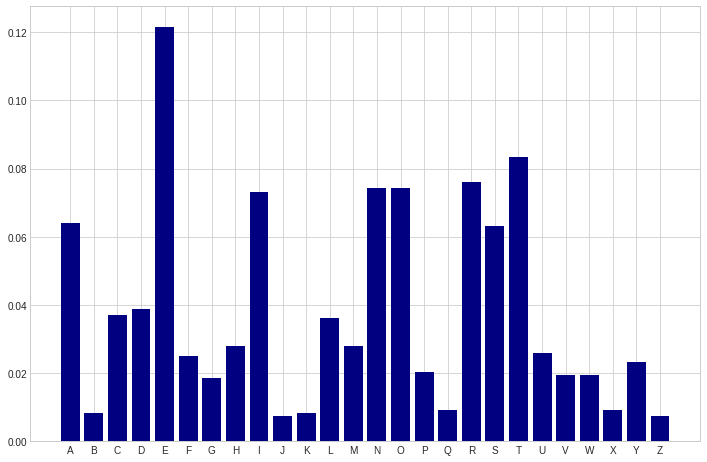

In [18]:
plt.figure(figsize=(12,8))
plt.bar(Eng_Char_Frq.keys(), Eng_Char_Frq.values(), color='navy')

Considering that we would use this corrispondence between numbers and letters :


In [19]:
Char_to_Numb = {
    'A' : 0,
    'B' : 1,
    'C' : 2,
    'D' : 3,
    'E' : 4,
    'F' : 5,
    'G' : 6,
    'H' : 7,
    'I' : 8,
    'J' : 9,
    'K' : 10,
    'L' : 11,
    'M' : 12,
    'N' : 13,
    'O' : 14,
    'P' : 15,
    'Q' : 16,
    'R' : 17,
    'S' : 18,
    'T' : 19,
    'U' : 20,
    'V' : 21,
    'W' : 22,
    'X' : 23,
    'Y' : 24,
    'Z' : 25 
}

In [20]:
Numb_to_Char = {
     0 : 'A',
     1 : 'B', 
     2 : 'C',
     3 : 'D',
     4 : 'E',
     5 : 'F',
     6 : 'G',
     7 : 'H',
     8 : 'I',
     9 : 'J',
    10 : 'K',
    11 : 'L',
    12 : 'M',
    13 : 'N',
    14 : 'O',
    15 : 'P',
    16 : 'Q',
    17 : 'R',
    18 : 'S',
    19 : 'T',
    20 : 'U',
    21 : 'V',
    22 : 'W',
    23 : 'X',
    24 : 'Y',
    25 : 'Z' 
}

By considering the 2nd substring, we can guess that the letter A corresponds to O, which means that 0 is traslated to 14, i.e. a +14 traslation.
This is motivated by the fact that the letter A has usually got an high frequency, yet it has several minima of the frequency before that which are given by the last letters of the alphabet, while its followed by letter B which has low frequency and 3 other letters with medium frequency.
This kind of substructure can be easily observed by eye in the plot of the second sub-string !
By translating the whole row and comparing with the original english frequencies we get :

In [21]:
Traslated_message = {}
Traslated_message[2] = ''
for i in range(len(Dec_mexs[2])):
    Traslated_message[2] += Numb_to_Char[(Char_to_Numb[Dec_mexs[2][i]] - 14)%26]

In [22]:
Frq_trasl = {}
Frq_trasl[2] = CharFrequencies(Traslated_message[2])

comparing with the standard english case :

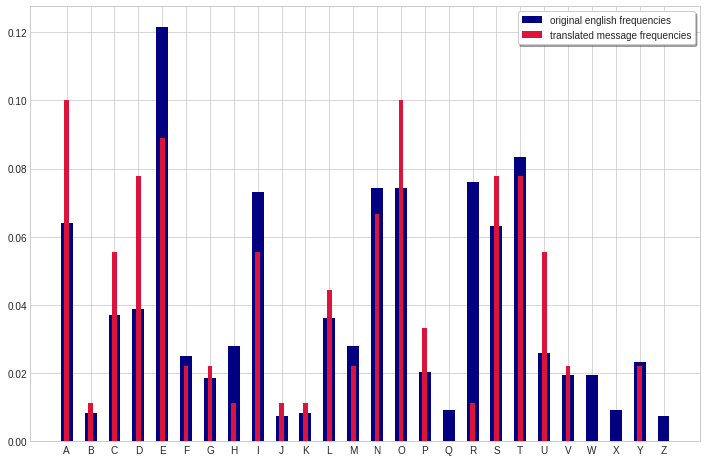

In [23]:
plt.figure(figsize=(12,8))
plt.bar(Eng_Char_Frq.keys(), Eng_Char_Frq.values(), width = 0.5, color='navy', label = 'original english frequencies')
plt.bar(Frq_trasl[2].keys() , Frq_trasl[2].values(), width = 0.2, color='crimson', label = 'translated message frequencies')

plt.legend(loc = 1, frameon = True, fancybox = True, shadow = True)

the results after the translation seems credible up to statistical fluctuations, which makes us think that we find at least one component of the key !
In order to find the other parts of the key, we just have to consider the [Mutual index of Coincidence](https://www.jfricker.com/blog/cryptanalysis-of-the-vigenere-cipher/) between two different substrings frequencies.
The function can be defined as follows :

In [26]:
def MIC_Analysis(Frq_char1, Frq_char2):
    # This function, receive two dictionaries with the frequency of each character of a text and return the values of its MIC for each of the possible shift 0 to 25 
    
    K_to_Mic = {
         0 : 0.,
         1 : 0., 
         2 : 0.,
         3 : 0.,
         4 : 0.,
         5 : 0.,
         6 : 0.,
         7 : 0.,
         8 : 0.,
         9 : 0.,
        10 : 0.,
        11 : 0.,
        12 : 0.,
        13 : 0.,
        14 : 0.,
        15 : 0.,
        16 : 0.,
        17 : 0.,
        18 : 0.,
        19 : 0.,
        20 : 0.,
        21 : 0.,
        22 : 0.,
        23 : 0.,
        24 : 0.,
        25 : 0. 
    }
    
    for k in range(26):
        for i in range(26):
                K_to_Mic[k] += Frq_char1[Numb_to_Char[i]]*Frq_char2[Numb_to_Char[(i + k)%26]]
    
    return K_to_Mic
            

we now just have to estimate the mutual index of the various substrings compared to the original english character frequencies, and find for each component of the key the value of k that give a value of the index closest to the one predicted for the english language (i.e. $0.06689$):

In [27]:
MIC_results = {}

for i in range(key_len):
    MIC_results[i] = MIC_Analysis(Eng_Char_Frq, Frq_submexs[i])

We can now start to define our key and filling in the components !

In [30]:
key_string = ''
key_numb = np.arange(key_len)

In [29]:
MIC_results[0]

{0: 0.06226551226551227,
 1: 0.0367759224902082,
 2: 0.03234384662956091,
 3: 0.03346732632446918,
 4: 0.03896103896103896,
 5: 0.03284889713461143,
 6: 0.034662956091527516,
 7: 0.036281179138321996,
 8: 0.0370645227788085,
 9: 0.042620078334364035,
 10: 0.03823953823953824,
 11: 0.04084724799010513,
 12: 0.03891981034838178,
 13: 0.047186147186147186,
 14: 0.0357555143269429,
 15: 0.042589156874871165,
 16: 0.040146361574933,
 17: 0.033766233766233764,
 18: 0.03417851989280562,
 19: 0.03592042877757164,
 20: 0.03571428571428572,
 21: 0.03543599257884972,
 22: 0.05031952174809316,
 23: 0.034353741496598644,
 24: 0.03167388167388168,
 25: 0.03766233766233767}

the value closest to the english IC for the first sub-string is the one with $k = 0$, we can hence choose :

In [32]:
key_numb[0] = 0
key_string += Numb_to_Char[0]

Keeping on for the other entries we have :

In [33]:
MIC_results[1]

{0: 0.03384869099154813,
 1: 0.03404452690166975,
 2: 0.039022881880024736,
 3: 0.06555349412492271,
 4: 0.03983714698000413,
 5: 0.03780663780663781,
 6: 0.033364254792826224,
 7: 0.04262007833436406,
 8: 0.030251494537208823,
 9: 0.03529169243454958,
 10: 0.03233353947639663,
 11: 0.030839002267573697,
 12: 0.037353123067408775,
 13: 0.03814677386105957,
 14: 0.04580498866213152,
 15: 0.03695114409400123,
 16: 0.04779426922284066,
 17: 0.03466295609152754,
 18: 0.0416924345495774,
 19: 0.03869305297876726,
 20: 0.04068233353947639,
 21: 0.03295196866625438,
 22: 0.035250463821892404,
 23: 0.034312512883941444,
 24: 0.03544629973201402,
 25: 0.04544423830138117}

In [34]:
key_numb[1] = 3
key_string += Numb_to_Char[3]

In [35]:
MIC_results[2]

{0: 0.03983714698000413,
 1: 0.03806431663574521,
 2: 0.03780663780663782,
 3: 0.04373325087610802,
 4: 0.04080601937744795,
 5: 0.03398268398268398,
 6: 0.03564213564213565,
 7: 0.029694908266336844,
 8: 0.03677592249020821,
 9: 0.038054009482580926,
 10: 0.046093588950731824,
 11: 0.03419913419913421,
 12: 0.03494124922696351,
 13: 0.03891981034838178,
 14: 0.05782312925170068,
 15: 0.04344465058750773,
 16: 0.03674500103071531,
 17: 0.029983508554937126,
 18: 0.034652648938363236,
 19: 0.03335394763966192,
 20: 0.03747680890538034,
 21: 0.03971346114203258,
 22: 0.03262213976499691,
 23: 0.03767264481550195,
 24: 0.04341372912801485,
 25: 0.0445475159760874}

In [36]:
key_numb[2] = 14
key_string += Numb_to_Char[14]

In [37]:
MIC_results[3]

{0: 0.04432075860647289,
 1: 0.03776540919398063,
 2: 0.041826427540713265,
 3: 0.03591012162440735,
 4: 0.04954648526077097,
 5: 0.04310451453308597,
 6: 0.03756957328385901,
 7: 0.0313440527726242,
 8: 0.03260152545866832,
 9: 0.038260152545866837,
 10: 0.0334467120181406,
 11: 0.042939600082457244,
 12: 0.029921665635951354,
 13: 0.03915687487116059,
 14: 0.03826015254586683,
 15: 0.06222428365285508,
 16: 0.03795093795093796,
 17: 0.0349721706864564,
 18: 0.0313337456194599,
 19: 0.04542362399505257,
 20: 0.03405483405483405,
 21: 0.03468357039785612,
 22: 0.03612657184085756,
 23: 0.03544629973201402,
 24: 0.038404452690166985,
 25: 0.0334054834054834}

In [38]:
key_numb[3] = 15
key_string += Numb_to_Char[15]

In [39]:
MIC_results[4]

{0: 0.03638425066996496,
 1: 0.0344671201814059,
 2: 0.03515769944341373,
 3: 0.033755926613069476,
 4: 0.042032570603999175,
 5: 0.03593073593073593,
 6: 0.04035250463821893,
 7: 0.03824984539270254,
 8: 0.04778396206967635,
 9: 0.03951762523191094,
 10: 0.0362914862914863,
 11: 0.034384662956091536,
 12: 0.03804370232941662,
 13: 0.03871366728509586,
 14: 0.0323953823953824,
 15: 0.040218511647083066,
 16: 0.03193156050298908,
 17: 0.03289012574726861,
 18: 0.03842506699649556,
 19: 0.06150278293135437,
 20: 0.04192949907235621,
 21: 0.03397237682951968,
 22: 0.03229231086373943,
 23: 0.044784580498866224,
 24: 0.04112554112554114,
 25: 0.03746650175221604}

In [40]:
key_numb[4] = 19
key_string += Numb_to_Char[19]

The final key is :

In [41]:
key_string

'ADOPT'

We can finally translate the sub-strings using the keys and recompose the message !

In [43]:
for k in range(key_len):
    Traslated_message[k] = ''
    for i in range(len(Dec_mexs[k])):
        Traslated_message[k] += Numb_to_Char[(Char_to_Numb[Dec_mexs[k][i]] - key_numb[k])%26]

plotting the final histograms comparing the translated frequencies of letters with the english one, we obtain :

In [50]:
for k in range(key_len):
     Frq_trasl[k] = CharFrequencies(Traslated_message[k])

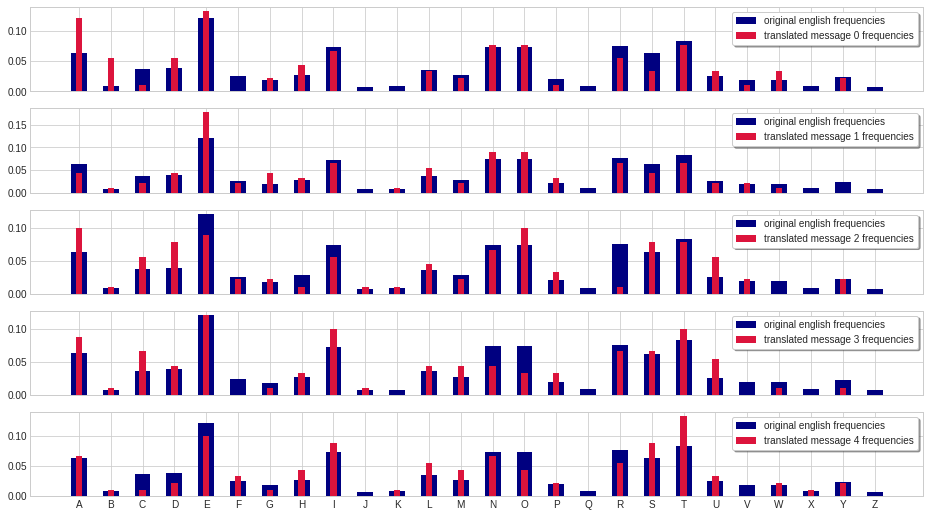

In [51]:
fig, ax = plt.subplots(key_len, 1, sharex='col', figsize = (16,9))
for i in range(key_len):
    ax[i].bar(Eng_Char_Frq.keys(), Eng_Char_Frq.values(), width = 0.5, color='navy', label = 'original english frequencies')
    ax[i].bar(Frq_trasl[i].keys() , Frq_trasl[i].values(), width = 0.2, color='crimson', label = 'translated message ' + str(i) + ' frequencies')
    ax[i].legend(loc = 1, frameon = True, fancybox = True, shadow = True)

The situation seems coherent, we can finally recompose our original message !

In [54]:
Decrypted_message = ''

for i in range(len(Encoded_mex)):
    Decrypted_message += Traslated_message[i%key_len][int(i/5)]

The final message is :

In [55]:
Decrypted_message

'TRUCKSCARRYINGSOLDIERSPASSEDDIPLOMATICANALYSTSSAYTHATOUTOFNERVOUSNESSABOUTTHECHINESEPEOPLEBEINGINSPIREDBYTHEREVOLUTIONINBUCHARESTBEIJINGAUTHORITIESMAYDECIDETOEXTENDMARTIALLAWUNTILTHEASIANGAMESSCHEDULEDFORSEPTEMBERREMOVINGMARTIALLAWWOULDBEASIGNALADIPLOMATSAIDPEOPLEWOULDTAKEITTOMEANTHATWHATHAPPENEDBEFORECOULDSTARTUPAGAININASTATECOUNCILMEETINGONWEDNESDAYMRLIDEFENDEDBEIJINGSUSEOFMILITARYFORCETOCRACKDOWNONTHESTUDENTMOVEMENTTHECRUSHINGOFTHECOUNTERREVOL'

with a bit of reordering, and adding some spaces, we get :

_TRUCKS CARRYING SOLDIERS PASSED,
DIPLOMATIC ANALYSTS SAY THAT, OUT OF NERVOUSNESS ABOUT THE CHINESE PEOPLE BEING INSPIRED BY THE REVOLUTION IN BUCHAREST, 
BEIJING AUTHORITIES MAY DECIDE TO EXTEND MARTIAL LAW UNTIL THE ASIAN GAMES SCHEDULED FOR SEPTEMBER.
REMOVING MARTIAL LAW WOULD BE A SIGNAL, A DIPLOMAT SAID PEOPLE WOULD TAKE IT TO MEAN THAT WHAT HAPPENED BEFORE COULD START UP AGAIN.
IN A STATE COUNCIL MEETING ON WEDNESDAY MRLI DEFENDED BEIJINGS USE OF MILITARY FORCE TO CRACK DOWN ON THE STUDENT MOVEMENT THE CRUSHING OF THE COUNTERREVOL_